In [1]:
%cd ..

w:\Projects\Diffusion Model\UNet-Diffusion


## Dataset

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import pandas as pd
from omegaconf import OmegaConf

In [3]:
config = OmegaConf.load('configs/train_config_256.yaml')
data_config = config.data
print(OmegaConf.to_yaml(data_config))

path: data/images/
parquet_path: data/celebA_dataset_high.parquet
image_size: 256
normalize: true
caption_path: data/captions.jsonl



### Dataset Class

In [5]:
# img_dir = os.path.join(data_dir, 'images/')
img_dir = config.data.path

# load images
valid_ext = ['png', 'jpg', 'jpeg', 'webp']

img_paths = sorted([
    os.path.relpath(os.path.join(root, f), img_dir).replace("\\", "/")
    for root, _, files in os.walk(img_dir)
    for f in files
    if os.path.splitext(f)[1][1:].lower() in valid_ext
])

print(f"Image Dir: {img_dir}")
print(f"Total images: {len(img_paths)}")
print(f"First 5 images: {img_paths[0:5]}")

Image Dir: data/images/
Total images: 62089
First 5 images: ['CelebA/high_res/000004.jpg', 'CelebA/high_res/000009.jpg', 'CelebA/high_res/000024.jpg', 'CelebA/high_res/000044.jpg', 'CelebA/high_res/000054.jpg']


In [6]:
# # Merge Captions

# # load captions from jsonl file
# import json
# import os
# custom_captions_path = 'data/custom_captions.jsonl'
# celebA_captions_path = 'data/celebA_captions.jsonl'

# custom_captions = {}
# if os.path.exists(custom_captions_path):
#     with open(custom_captions_path, 'r', encoding='utf-8') as f:
#         for line in f:
#             entry = json.loads(line)
#             custom_captions[entry["file_name"]] = entry["text"]

# celebA_captions = {}
# if os.path.exists(celebA_captions_path):
#     with open(celebA_captions_path, 'r', encoding='utf-8') as f:
#         for line in f:
#             entry = json.loads(line)
#             celebA_captions[entry["file_name"]] = entry["text"]

# # merge clebA captions with custom captions
# merged_captions = {**celebA_captions, **custom_captions}

# # save merged captions to jsonl file
# with open('data/captions.jsonl', 'w', encoding='utf-8') as f:
#     for file, caption in merged_captions.items():
#         entry = {"file_name": file, "text": caption}
#         f.write(json.dumps(entry) + '\n')

# print(f"CelebA Captions: {len(celebA_captions)} | Custom Captions: {len(custom_captions)} | Total Captions: {len(merged_captions)}")
# print(f"Caption file Saved!")

In [6]:
# load captions

import json
captions = {}
file_path = 'data/captions.jsonl'
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        entry = json.loads(line)
        captions[entry["file_name"]] = entry["text"]

print(f"Captions: {len(captions)}")
captions

Captions: 220934


{'000001.jpg': 'A young woman who is brown hair, straight hair, arched eyebrows, smiling, pointy nose, high cheekbones, mouth slightly open, wearing earrings, wearing lipstick, and heavy makeup.',
 '000002.jpg': 'Portrait of a young woman brown hair, smiling, big nose, high cheekbones, bags under eyes, mouth slightly open, and without heavy makeup.',
 '000003.jpg': 'Portrait of a young man wavy hair, big lips, pointy nose, narrow eyes, and without heavy makeup.',
 '000004.jpg': 'Portrait of a young woman straight hair, pointy nose, wearing earrings, wearing lipstick, wearing necklace, and without heavy makeup.',
 '000005.jpg': 'Portrait of a young woman arched eyebrows, big lips, pointy nose, narrow eyes, wearing lipstick, and heavy makeup.',
 '000006.jpg': 'Portrait of a young woman brown hair, wavy hair, arched eyebrows, big lips, mouth slightly open, wearing earrings, wearing lipstick, and heavy makeup.',
 '000007.jpg': 'This is a young man black hair, straight hair, 5 o clock shado

Filename: 000168.jpg
Caption: This is a young woman black hair, straight hair, arched eyebrows, bushy eyebrows, smiling, big nose, pointy nose, high cheekbones, mouth slightly open, wearing earrings, wearing lipstick, wearing necklace, and heavy makeup.


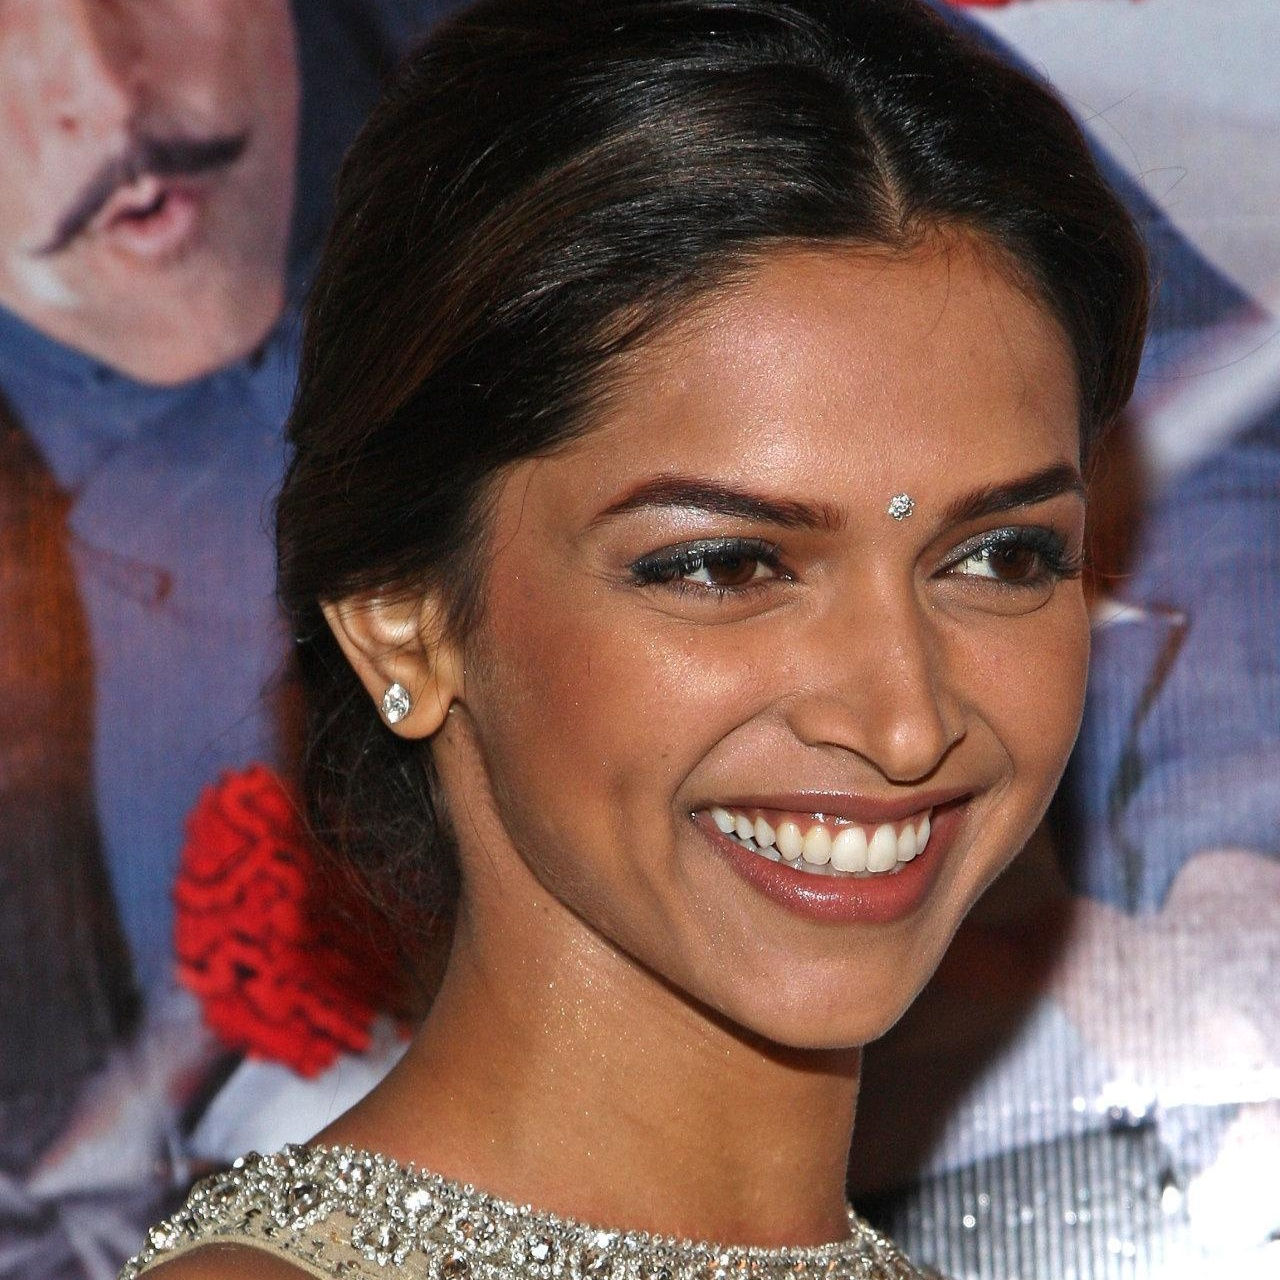

In [9]:
# === ACCESS EXAMPLE IMAGES ===
idx = 15
default_cap = "A beautiful portrait of a person"
img_path = os.path.join(img_dir, img_paths[idx])
img_basename = os.path.basename(img_path)
caption = captions.get(img_basename, default_cap)

img = Image.open(img_path).convert('RGB')

print("Filename:", img_basename)
print("Caption:", caption)
display(img)

In [11]:
T = transforms.Compose([
    transforms.Resize(data_config.image_size),
    transforms.CenterCrop(data_config.image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img_tensor = T(img)
print("Tensor shape:", img_tensor.shape)

img_tensor # [-1, 1]

Tensor shape: torch.Size([3, 256, 256])


tensor([[[ 0.2627,  0.3412,  0.3882,  ...,  0.3882,  0.4039,  0.4118],
         [ 0.2941,  0.3569,  0.3961,  ...,  0.3961,  0.4196,  0.4275],
         [ 0.3020,  0.3490,  0.3882,  ...,  0.4118,  0.4118,  0.4039],
         ...,
         [-0.1294, -0.1843, -0.2941,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2941, -0.3490, -0.4196,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4431, -0.4745, -0.4745,  ...,  1.0000,  1.0000,  1.0000]],

        [[-0.1373, -0.0588, -0.0118,  ...,  0.4980,  0.4902,  0.4824],
         [-0.1216, -0.0588, -0.0196,  ...,  0.5059,  0.5059,  0.4902],
         [-0.1059, -0.0745, -0.0667,  ...,  0.4980,  0.4902,  0.4745],
         ...,
         [-0.1529, -0.2157, -0.3176,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3176, -0.3725, -0.4431,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4745, -0.4980, -0.5059,  ...,  1.0000,  1.0000,  1.0000]],

        [[-0.1686, -0.0902, -0.0431,  ...,  0.5843,  0.5843,  0.5843],
         [-0.1529, -0.0902, -0.0510,  ...,  0

In [10]:
#============================= ## ====================================   

# Dataset and dataloader

In [12]:
# cd ..

In [13]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from utils.celeba_with_caption import CelebADataset, CelebAloader
from omegaconf import OmegaConf

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

config = OmegaConf.load('configs/train_config_256.yaml')
data_config = config.data
print(OmegaConf.to_yaml(data_config))

path: data/images/
parquet_path: data/celebA_dataset_high.parquet
image_size: 256
normalize: true
caption_path: data/captions.jsonl



In [14]:
# load data
dataset = CelebADataset(config=data_config)

In [15]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

# dataloader.__getstate__()

In [4]:
# # load data
# dataset = CelebADataset(config=data_config)
# dataloader, _ = CelebAloader(data_config=data_config, train_config=config.training, device=device)

# from torch.utils.data import DataLoader

In [26]:
print(f"Dataset size: {len(dataloader.dataset)} images, batch size: {dataloader.batch_size}")

batch = next(iter(dataloader)) 
print(f"Batch image shape: {batch['image'].shape}, Batch captions: {len(batch['caption'])}, Batch images path: {len(batch['img_path'])}")

Dataset size: 62089 images, batch size: 4
Batch image shape: torch.Size([4, 3, 256, 256]), Batch captions: 4, Batch images path: 4


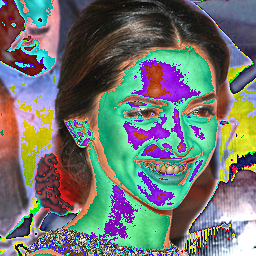

In [18]:
idx = 15

tensor_image = dataset.__getitem__(idx)['image']

from torchvision.transforms.functional import to_pil_image

to_pil_image(tensor_image)


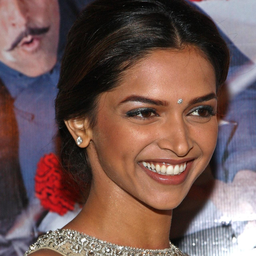

In [19]:
import torchvision.transforms as transforms

# Create the denormalization transform
denorm = transforms.Normalize(
    mean=[-1, -1, -1],  # = -mean / std = -0.5 / 0.5
    std=[2, 2, 2]       # = 1 / std = 1 / 0.5
)
denorm_img = denorm(tensor_image)

to_pil_image(denorm_img)


In [27]:
images = batch['image']          # Tensor: [B, C, H, W]
img_path = batch['img_path']      # List[str]
caps = batch['caption']
batch_size = images.size(0)

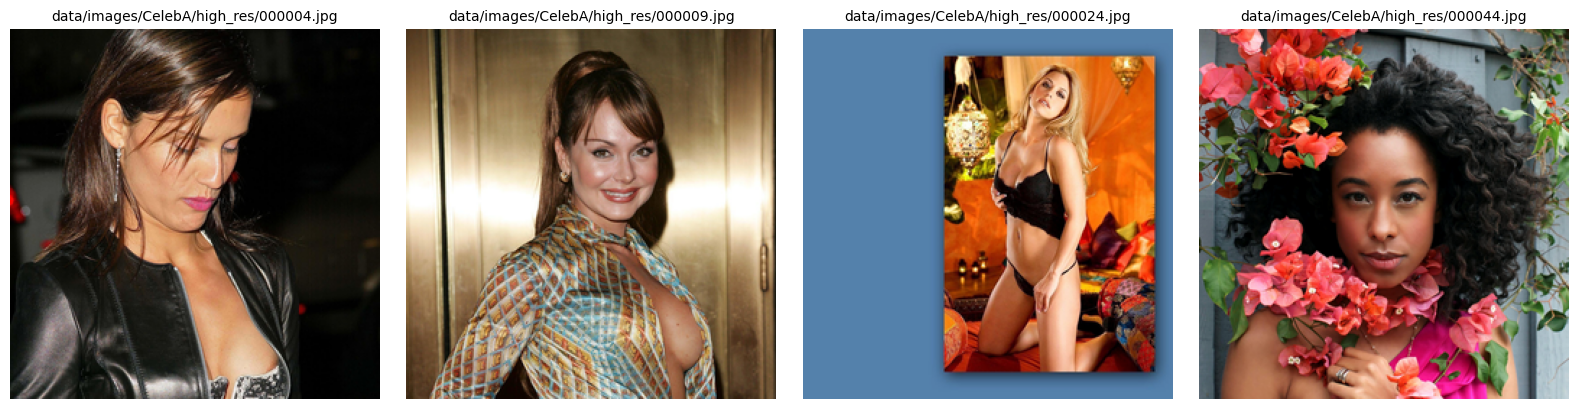

In [28]:
# Plot individual images
cols = min(batch_size, 4)
rows = (batch_size + cols - 1) // cols

plt.figure(figsize=(4 * cols, 4 * rows))

for i in range(batch_size):
    img = images[i].detach().cpu()
    # Create the denormalization transform
    denorm = transforms.Normalize(
        mean=[-1, -1, -1],  # = -mean / std = -0.5 / 0.5
        std=[2, 2, 2]       # = 1 / std = 1 / 0.5
    )
    img = denorm(img)

    img = F.to_pil_image(img)  # Convert to PIL.Image
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(img_path[i], fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [29]:
caps

['Portrait of a young woman straight hair, pointy nose, wearing earrings, wearing lipstick, wearing necklace, and without heavy makeup.',
 'A young woman with bangs, arched eyebrows, smiling, big lips, pointy nose, high cheekbones, oval face, rosy cheeks, mouth slightly open, wearing earrings, wearing lipstick, and heavy makeup.',
 'A young woman who is blond hair, arched eyebrows, big lips, mouth slightly open, wearing earrings, wearing lipstick, wearing necklace, and heavy makeup.',
 'This is a young woman black hair, bushy eyebrows, big lips, big nose, bags under eyes, wearing lipstick, wearing necklace, and without heavy makeup.']

# Parquet Dataset

In [1]:
cd ..

w:\Projects\Diffusion Model\UNet-Diffusion


In [2]:
import torch
import io
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from utils.celeba_parquet_dataset  import ImageDataset, DatasetLoader
from omegaconf import OmegaConf

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

config = OmegaConf.load('configs/train_config_256.yaml')
print(OmegaConf.to_yaml(config.data))

path: data/images/
parquet_path: data/celebA_dataset_high.parquet
image_size: 256
normalize: true
caption_path: data/captions.jsonl



In [4]:
# dataset = ImageDataset(config=config.data)

In [5]:
# dataloader = DatasetLoader(data_config=config.data, train_config=config.training)

In [ ]:
# dataloader.__getstate__()

In [14]:
from torch.utils.data import DataLoader

dataset = ImageDataset(config=config.data)
dataloader = DataLoader(
    dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

# dataloader.__getstate__()

In [15]:
dataloader.dataset.df

image_id                                              image  \
0       000004  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
1       000009  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
2       000024  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
3       000044  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
4       000054  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
...        ...                                                ...   
12283   202564  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
12284   202572  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
12285   202582  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
12286   202591  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
12287   202595  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   

                                                    text  
0      Portrait of a young woman straight hair, point...  
1      A young woman with bangs, arched eyebrows, smi...  
2      A young woman who is blond hair, arched eyebro...  
3      This is a young woman black hair, bushy eyebro...  
4      A young woman with blond hair, wavy hair, arch...  
...                                                  ...  
12283  A young woman who is black hair, arched eyebro...  
12284  This is a young woman black hair, wavy hair, a...  
12285  Portrait of a young woman bangs, smiling, big ...  
12286  This is a young woman black hair, straight hai...  
12287  A young woman with blond hair, big lips, weari...  

[12288 rows x 3 columns]

In [16]:
batch = next(iter(dataloader))

# print(f"Total Images in batch: {len(batch['image'])}")
# Total Images in batch: 4

In [17]:
from torchvision.transforms.functional import to_pil_image

def tensor_to_pil(tensor):
    tensor = tensor * 0.5 + 0.5  # Denormalize
    tensor = tensor.clamp(0, 1)  # Ensure no overflow
    return to_pil_image(tensor)

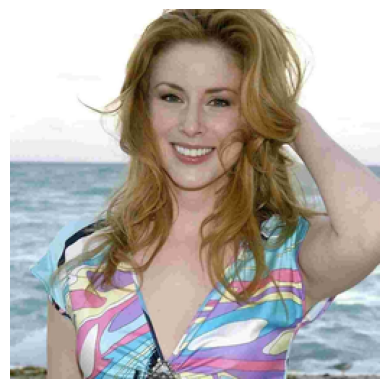

Caption:  This is a young woman blond hair, wavy hair, arched eyebrows, smiling, high cheekbones, pale skin, mouth slightly open, wearing lipstick, and heavy makeup.


In [22]:
first_image_tensor = batch['image'][0]
cap = batch['text'][0]
first_image = tensor_to_pil(first_image_tensor)

plt.imshow(first_image)
plt.axis('off')
plt.show()

print("Caption: ", cap)

In [20]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def tensor_to_pil(tensor):
    tensor = tensor * 0.5 + 0.5  # De-normalize from [-1, 1] to [0, 1]
    tensor = tensor.clamp(0, 1)
    return ToPILImage()(tensor)

def show_batch_with_ids(batch, ncols=4, title_key='image_id'):
    images = batch['image']
    titles = batch.get(title_key, None)

    batch_size = len(images)
    nrows = (batch_size + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))
    axes = axes.flatten()

    for idx in range(batch_size):
        img = tensor_to_pil(images[idx])
        title = titles[idx] if titles is not None else f"#{idx}"

        axes[idx].imshow(img)
        axes[idx].set_title(str(title), fontsize=10)
        axes[idx].axis('off')

    # Hide unused subplots if batch size < nrows * ncols
    for idx in range(batch_size, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


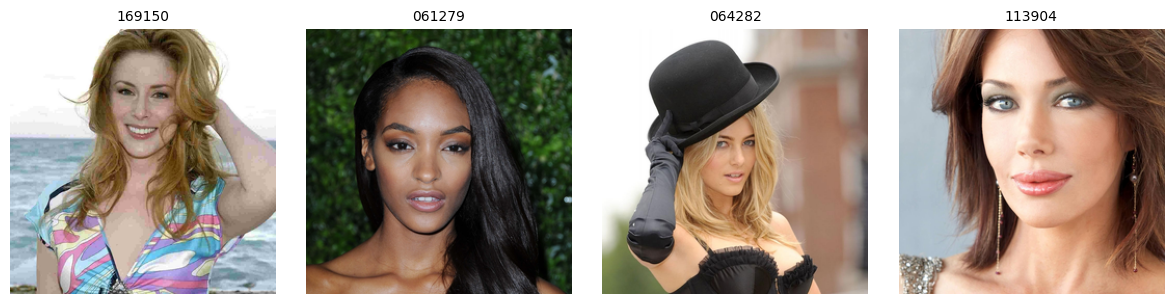

In [21]:
batch = next(iter(dataloader))
show_batch_with_ids(batch, ncols=4)

In [21]:
batch['text']

['Portrait of a young woman blond hair, straight hair, arched eyebrows, big lips, pointy nose, wearing earrings, wearing lipstick, and heavy makeup.',
 'Portrait of a young woman arched eyebrows, smiling, pointy nose, high cheekbones, oval face, mouth slightly open, wearing lipstick, wearing necklace, and heavy makeup.',
 'This is a young woman pointy nose, mouth slightly open, wearing lipstick, and without heavy makeup.',
 'This is a young woman smiling, big lips, big nose, pointy nose, high cheekbones, bags under eyes, mouth slightly open, and without heavy makeup.']